In [ ]:
import os

os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"

In [ ]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import *
import numpy as np
from scipy import constants
from numba import jit
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import h5py
import matplotlib.pyplot as plt

In [ ]:
def read_high_res_data(data_dir, method="sysrem", spectrum_type="transmission"):
    """
    Read an external dataset file. The expected file format is:

    TODO: Could combine with read_data or put in high_res.py

    Args:
        data_dir (str):
            Path to the directory containing the data file.
        method (str):
            Detrending method. Options: 'pca', 'sysrem'.
    Returns:
        data (dict): {
            'wl_grid': wavelength grid of the data,
            'data_arr': extracted signal,
            'data_scale': removed principle components,
            'data_raw': data cube in original form,
            'Phi': time-resolved phases,
            'V_bary': time-resolved barycentric velocity   }

    """

    # Load data file
    phi = pickle.load(open(data_dir + "/phi.pic", "rb"))
    data = {
        "phi": phi,
        "method": method,
        "spectrum_type": spectrum_type,
        "data_dir": data_dir,
        "high_res": True,
    }
    if method == "pca" and spectrum_type == "emission":
        wl_grid, data_arr = pickle.load(open(data_dir + "/data_arr.pic", "rb"))
        wl_grid, data_scale = pickle.load(open(data_dir + "/data_scale.pic", "rb"))
        V_bary = pickle.load(
            open(data_dir + "/V_bary.pic", "rb")
        )  # Time-resolved Earth-star velocity (V_bary+V_sys) constructed in make_data_cube.py; then V_sys = V_sys_literature + d_V_sys
        data["wl_grid"] = wl_grid
        data["data_arr"] = data_arr
        data["data_scale"] = data_scale
        data["V_bary"] = V_bary

    elif method == "sysrem" and spectrum_type == "transmission":
        wl_grid, data_raw = pickle.load(open(data_dir + "/data_raw.pic", "rb"))
        transit_weight = pickle.load(open(data_dir + "/transit_weight.pic", "rb"))
        data["wl_grid"] = wl_grid
        data["data_raw"] = data_raw
        data["transit_weight"] = transit_weight
        if os.path.isfile(data_dir + "/uncertainties.pic"):
            data["uncertainties"] = pickle.load(
                open(data_dir + "/uncertainties.pic", "rb")
            )
        else:
            print(
                "Uncertainties array not constructed yet. Please construct one before running retrievals."
            )

        if os.path.isfile(data_dir + "/fast_filter.pic"):
            Bs, residuals = pickle.load(open(data_dir + "/fast_filter.pic", "rb"))
            data["Bs"] = Bs
            data["residuals"] = residuals
        else:
            print(
                "Fast filter has not been run yet. Please save the basis array (Bs) for each order and the residuals before running retrievals."
            )

    else:
        raise Exception(
            "Error: This combination of filtering method and spectrum type not supported."
        )

    return data

In [ ]:
data_dir = "./data/WASP-76b-MAROON/"
nights = ["night_1", "night_2", "night_3", "night_4", "night_5", "night_6"]
names = [
    "night_1_blue",
    "night_1_red",
    "night_2_blue",
    "night_2_red",
    "night_3_blue",
    "night_3_red",
]

In [ ]:
for i in range(len(nights)):
    data = read_high_res_data(
        data_dir + nights[i], method="sysrem", spectrum_type="transmission"
    )
    flux = data["data_raw"]
    wl_grid = data["wl_grid"][:]
    phi = data["phi"]
    tranist_weight = data["transit_weight"]
    flux = remove_outliers(wl_grid, flux)
    add_high_res_data(
        data_dir,
        names[i],
        flux,
        wl_grid,
        phi,
        tranist_weight,
        overwrite=False,
    )

In [ ]:
for name in names:
    prepare_high_res_data(
        data_dir,
        name,
        "transmission",
        "sysrem_2022",
        overwrite=False,
        Print=True,
        niter=15,
        n_PC=5,
    )

In [ ]:
from POSEIDON.core import define_model, wl_grid_constant_R

# ***** Define stellar properties *****#

R_s = 1.756 * R_Sun  # Stellar radius (m)
T_s = 6250  # Stellar effective temperature (K)
Met_s = 0.23  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.13  # Stellar log surface gravity (log10(cm/s^2) by convention)

# ***** Define planet properties *****#

planet_name = "WASP-76b"  # Planet name used for plots, output files etc.

R_p = 1.830 * R_J  # Planetary radius (m)
M_p = 0.92 * M_J  # Mass of planet (kg)
g_p = 10 ** (2.83 - 2)  # Gravitational field of planet (m/s^2)
T_eq = 2182  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# ***** Define model *****#

model_name = "Fe -6"  # Model name used for plots, output files etc.
bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
# for species in ["Fe", "Li", "Mg", "Ti"]:
species = "VO"
param_species = [species]

model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="isotherm",
    cloud_model="MacMad17",
    cloud_type="deck",
)
# cloud_model="MacMad17", cloud_type="deck")

# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))

# ***** Wavelength grid *****#
wl_min = 0.40  # Minimum wavelength (um) 0.37
wl_max = 1.00  # Maximum wavelength (um) 1.05
R = 250000  # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_grid="phoenix")

# ***** Read opacity data *****#

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 2000  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 4000  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -12.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

In [ ]:
model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="isotherm",
    cloud_model="MacMad17",
    cloud_type="deck",
)
# Specify the pressure grid of the atmosphere
P_min = 1.0e-12  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-2  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

params = (-9, 3500)
log_species, T = params

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([T])  # a1, a2, log_P1, log_P2, log_P3, T_deep
log_X_params = np.array([[log_species]])
cloud_params = np.array([-3])

atmosphere = make_atmosphere(
    planet, model, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params
)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet,
    star,
    model,
    atmosphere,
    opac,
    wl,
    spectrum_type="transmission",
)

In [ ]:
def cross_correlate(
    Kp_range, Vsys_range, RV_range, wl, planet_spectrum, data, Print=True
):
    if Print:
        time0 = time.time()
    uncertainties = data["uncertainties_processed"]
    residuals = data["residuals"]
    phi = data["phi"]
    wl_grid = data["wl_grid"]
    transit_weight = data["transit_weight"]
    max_transit_depth = np.max(1 - transit_weight)

    norder, nphi, npix = residuals.shape
    CCF_Kp_Vsys = np.zeros((len(Kp_range), len(Vsys_range)))

    nRV = len(RV_range)
    CCF_phase_RV = np.zeros((nphi, nRV))
    models_shifted = np.zeros((nRV, norder, npix))
    for RV_i, RV in enumerate(RV_range):
        # Looping through each order and computing total log-L by summing logLs for each obvservation/order
        for order_i in range(norder):
            wl_slice = wl_grid[order_i]  # Cropped wavelengths
            delta_lambda = RV * 1e3 / constants.c
            wl_shifted = wl * (1.0 + delta_lambda)
            F_p = np.interp(wl_slice, wl_shifted, planet_spectrum)
            models_shifted[RV_i, order_i] = F_p  # choose not to filter

    # negative of transmission spectrum gives absorption. Adding or multiplying constant does not change the CCF
    m = -models_shifted
    # already minus mean in prepare_data

    for phi_i in range(nphi):
        for RV_i in range(nRV):
            f = residuals[:, phi_i, :]
            CCF = np.sum(f[:, :] * m[RV_i, :, :] / uncertainties[:, phi_i, :] ** 2)
            CCF_phase_RV[phi_i, RV_i] += CCF

    CCF_phase_RV = (1 - transit_weight[:, None]) * CCF_phase_RV

    for Kp_i, Kp in enumerate(Kp_range):
        for phi_i in range(nphi):
            RV = Kp * np.sin(2 * np.pi * phi[phi_i]) + Vsys_range
            CCF_Kp_Vsys[Kp_i] += np.interp(RV, RV_range, CCF_phase_RV[phi_i])
    if Print:
        time1 = time.time()
        print("Cross correlation took {} seconds".format(time1 - time0))
    return CCF_Kp_Vsys, CCF_phase_RV

In [ ]:
import PyAstronomy as pyasl
import POSEIDON


def airtovac(wlA):
    # Convert wavelengths (nm) in air to wavelengths in vaccuum (empirical).
    s = 1e4 / wlA
    n = 1 + (
        0.00008336624212083
        + 0.02408926869968 / (130.1065924522 - s**2)
        + 0.0001599740894897 / (38.92568793293 - s**2)
    )
    return wlA * n


data_dir = "./data/WASP-76b-MAROON/"
data = POSEIDON.high_res.read_high_res_data(data_dir, names=names)

spectrum = np.load(data_dir + "models/VO.npy")
model_wave = np.load(data_dir + "models/wave.npy")
# model_wave = wl
# model_wave = airtovac(wl * 1e4) / 1e4

In [ ]:
# from scipy.ndimage import gaussian_filter1d, minimum_filter1d

# plt.plot(
#     wl,
#     spectrum,
#     label="POSEIDON",
# )

# # spectrum = np.load(data_dir + "models/VO.npy")
# model_wave = np.load(data_dir + "models/wave.npy")
# plt.plot(model_wave, np.load(data_dir + "models/VO.npy") / 1e6, label="Pelletier")
# plt.legend()
# plt.xlim(0.5, 0.9)

In [239]:
from scipy.ndimage import gaussian_filter1d, maximum_filter1d, minimum_filter1d

Kp_range = np.arange(-300, 301, 1)
Vsys_range = np.arange(-100, 101, 1)
RV_range = np.arange(-400, 401, 1)

CCF_Kp_Vsys_all = []
CCF_phase_RV_all = []
for key in data.keys():
    CCF_Kp_Vsys, CCF_phase_RV = cross_correlate(
        Kp_range,
        Vsys_range,
        RV_range,
        model_wave,
        # spectrum - gaussian_filter1d(minimum_filter1d(spectrum, 1400), 400),
        spectrum,
        data[key],
    )
    CCF_Kp_Vsys_all.append(CCF_Kp_Vsys)
    CCF_phase_RV_all.append(CCF_phase_RV)
CCF_phase_RV_all = np.array(CCF_phase_RV_all)
CCF_Kp_Vsys_all = np.array(CCF_Kp_Vsys_all)

Cross correlation took 21.30202555656433 seconds
Cross correlation took 18.2235324382782 seconds
Cross correlation took 17.487167596817017 seconds
Cross correlation took 14.741638898849487 seconds


In [240]:
# CCF_Kp_Vsys_all[3]=0

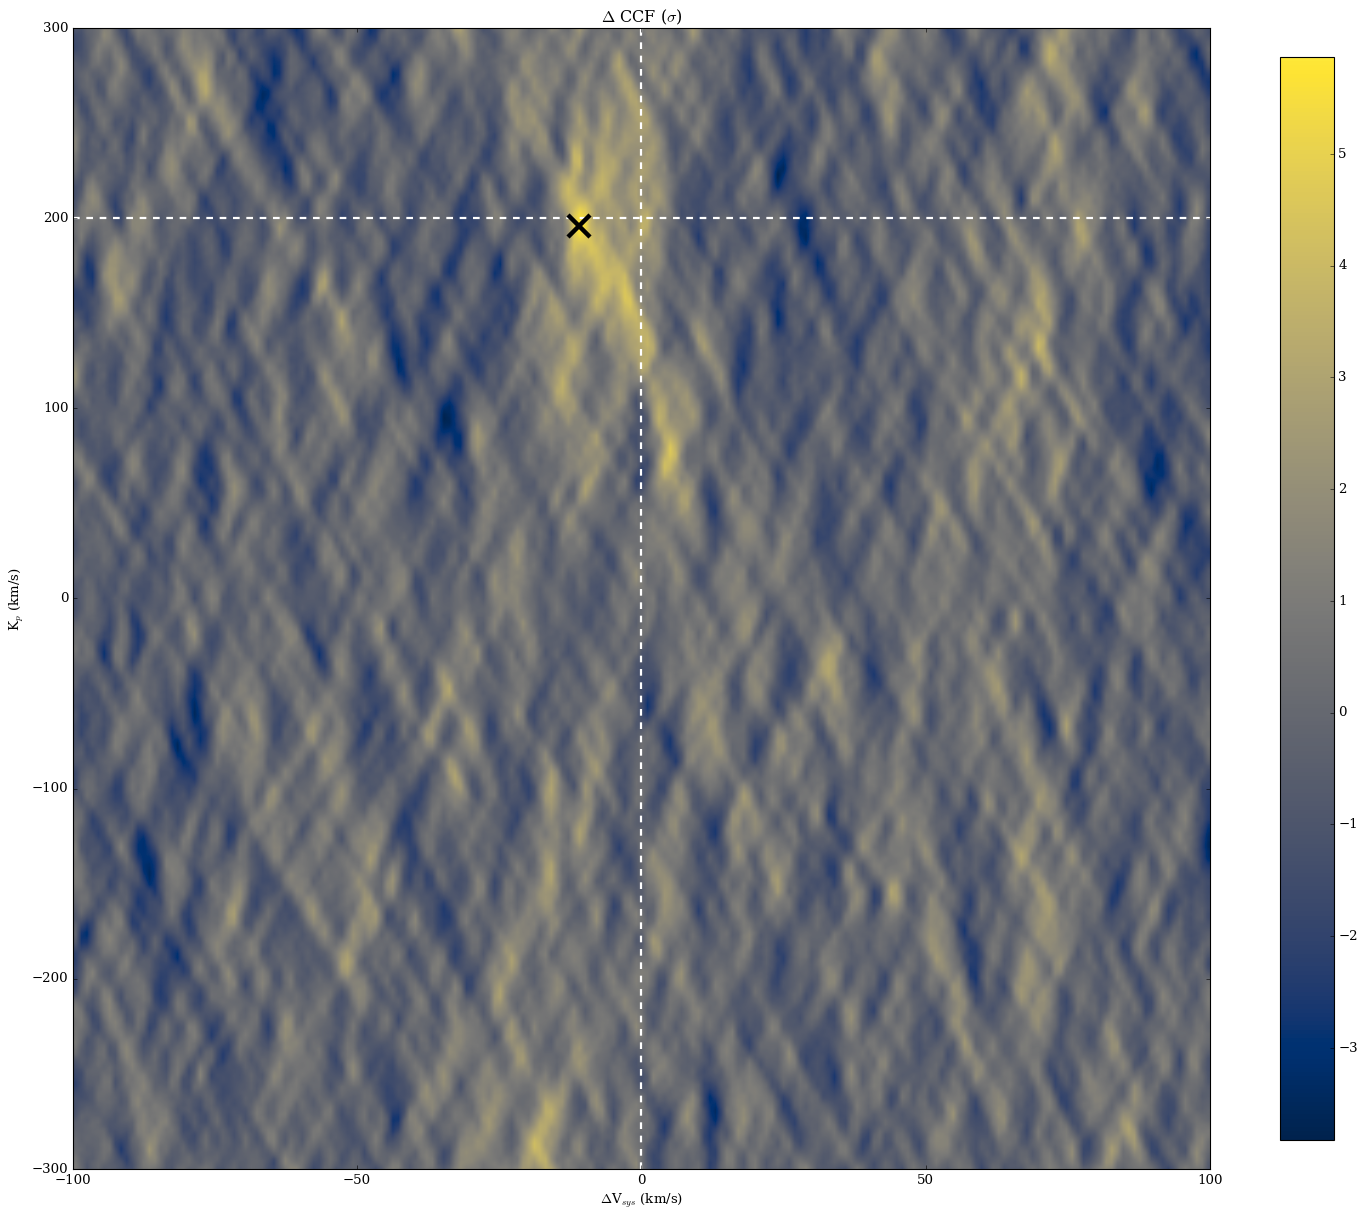

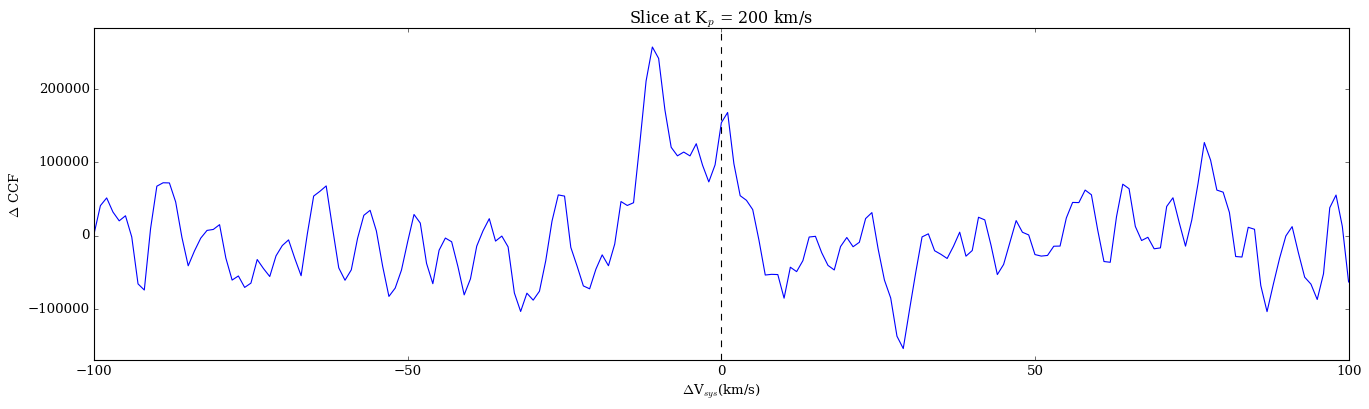

In [241]:
plot_CCF_Kp_Vsys(
    Kp_range,
    Vsys_range,
    np.sum(CCF_Kp_Vsys_all[:], axis=0),
    "Fe",
    200,
    Vsys=0,
    RM_mask_size=20,
)